In [1]:
# !pip install pykrige

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import geopandas as gpd
from shapely.geometry import Point
from pykrige.ok import OrdinaryKriging
from sklearn.metrics import root_mean_squared_error

import sys
sys.path.insert(0, './')
from functions import *
pd.set_option('display.max_columns', None)

## Import Cleaned Data

In [3]:
acs = pd.read_parquet("Data/Cleaned/ACS.parquet")
citibike =  pd.read_parquet("Data/Cleaned/Citibike_Clean/citibike_all_processed.parquet")

In [4]:
# ACS and Citibike

df = acs.merge(citibike, on=['GEOID','year'], how='left')
df['num_citibike_rides'] = df['num_citibike_rides'].fillna(0)


In [5]:
## Tree Census

tree = pd.read_parquet("Data/Cleaned/tree_census.parquet")
tree['year'] = tree['year'].astype(str)
df = df.merge(tree, on=['GEOID', 'year'], how='left')


In [6]:
## Zillow Data

zillow = pd.read_parquet("Data/Cleaned/zillow_clean.parquet")
zillow['year'] = zillow['year'].astype(str)
df = df.merge(zillow, on=['GEOID','year'], how='left')


In [7]:
## Affordable Housing Projects

housing = pd.read_parquet("Data/Cleaned/affordable_housing.parquet")
housing['year'] = housing['year'].astype(str)
df = df.merge(housing, on=['GEOID','year'], how='left')
df['num_affordable_hous_built'] = df['num_affordable_hous_built'].fillna(0)


In [8]:
## Bikelanes

bikelanes = pd.read_parquet("Data/Cleaned/bikelanes.parquet")
df = df.merge(bikelanes, on=['GEOID','year'], how='left')
df['num_bikelanes'] = df['num_bikelanes'].fillna(0)


In [9]:
## Evictions

evictions = pd.read_parquet("Data/Cleaned/evictions.parquet")
evictions['year'] = evictions['year'].astype(str)
df = df.merge(evictions, on=['GEOID','year'], how='left')


In [10]:
## Parks

parks = pd.read_parquet("Data/Cleaned/parks.parquet")
df = df.merge(parks, on=['GEOID','year'], how='left')
df['park_acres'] = df['park_acres'].fillna(0)
df['num_parks'] = df['num_parks'].fillna(0)


In [11]:
# df.to_parquet('Data/Cleaned/before_kriging.parquet')

In [12]:
df.describe()

,total_pop,percent_hh_income_assist,percent_hh_snap,percent_hh_english,percent_work_agriculture,percent_work_construction,percent_work_retail,percent_work_finance,percent_work_stem,percent_work_edu_health,percent_work_art,percent_out_of_county,percent_moved_within_county,percent_public_transit,percent_drive_commute,percent_bike_commute,percent_walk_commute,percent_wfh,percent_white,percent_black,percent_native,percent_asian,percent_pacific,percent_latino,percent_bachelors,percent_grad,percent_born_citizen,percent_naturalized_citizen,percent_not_citizen,percent_same_house_1yr,percent_out_of_state,med_income,med_rent_acs,med_age,percent_hh_rented,med_value,percent_hh_electric,percent_hh_solar,med_hh_age,med_hh_tenure,num_citibike_rides,num_trees,med_rent,num_affordable_hous_built,num_bikelanes,num_evictions_commercial,num_evictions_residential,park_acres,num_parks
count,30979.000000,30096.000000,30096.000000,30096.000000,30140.000000,30140.000000,30140.000000,30140.000000,30140.000000,30140.000000,30140.000000,30223.000000,30223.000000,30223.000000,30223.000000,30223.000000,30223.000000,30223.000000,30223.000000,30223.000000,30223.000000,30223.000000,30223.000000,30223.000000,30223.000000,30223.000000,30223.000000,30223.000000,30223.000000,30223.000000,30223.000000,29854.000000,29710.000000,30166.000000,30096.000000,2.747400e+04,30096.000000,30096.000000,29943.000000,29882.000000,3.442600e+04,32354.000000,30171.000000,34426.000000,34426.000000,31234.000000,31234.000000,34426.000000,34426.000000
mean,3796.011266,0.045349,0.203340,0.497391,0.001108,0.054130,0.096438,0.088425,0.122926,0.280453,0.099684,0.020693,0.057603,0.240723,0.135335,0.004874,0.042020,0.027971,0.419265,0.254878,0.004479,0.138697,0.000576,0.267907,0.147690,0.102077,0.592849,0.210117,0.161320,0.885887,0.013720,66947.918671,1465.756244,37.319714,0.409783,6.384007e+05,0.091562,0.000507,64.773269,19.866107,1.182021e+04,286.877697,2273.264041,0.234125,9.207605,0.404015,5.739659,61.486965,1.017574
std,2177.840906,0.045000,0.157606,0.220496,0.005412,0.046088,0.047764,0.061516,0.069163,0.100740,0.064087,0.032345,0.043068,0.097153,0.091137,0.009506,0.052876,0.035510,0.296976,0.298249,0.012342,0.167104,0.006415,0.226305,0.090127,0.095554,0.153110,0.103067,0.098014,0.077149,0.025174,34839.481436,510.552872,6.947215,0.360797,3.152925e+05,0.108088,0.003733,27.023834,5.113665,4.993394e+04,278.224662,647.712820,1.174418,18.280652,0.936880,7.880943,224.079355,1.402295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2499.000000,231.000000,1.900000,0.000000,9.999000e+03,0.000000,0.000000,0.000000,3.000000,0.000000e+00,0.000000,787.929593,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2311.000000,0.013004,0.080411,0.315179,0.000000,0.021731,0.064072,0.049235,0.076116,0.210351,0.055944,0.003792,0.028427,0.174580,0.063119,0.000000,0.013372,0.007119,0.139745,0.019841,0.000000,0.021333,0.000000,0.092324,0.082892,0.035827,0.484472,0.127251,0.090909,0.856664,0.000000,42500.000000,1161.000000,32.800000,0.000000,4.382000e+05,0.028673,0.000000,61.000000,16.000000,0.000000e+00,145.000000,1882.981341,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,3482.000000,0.032258,0.163224,0.501424,0.000000,0.045590,0.091442,0.075598,0.107873,0.275291,0.087604,0.012868,0.050197,0.234739,0.112792,0.000000,0.027549,0.016487,0.381617,0.098377,0.000000,0.071549,0.000000,0.186314,0.127891,0.071510,0.591422,0.199155,0.142747,0.900990,0.005180,61071.000000,1389.000000,36.700000,0.411596,5.750000e+05,0.056800,0.000000,73.000000,20.000000,0.000000e+00,219.000000,2240.881264,0.000000,2.000000,0.000000,3.000000,0.065000,1.000000
75%,4877.000000,0.064449,0.290485,0.687449,0.000000,0.075194,0.122960,0.110321,0.154073,0.344781,0.130918,0.027701,0.077365,0.300480,0.19

# Kriging Spatial Interpolation
needs to happen for each column & year individually

In [13]:
# retrieve spatial coordinates for each county

# Load the census tract shapefile
nyc_tracts = gpd.read_file('Data/Raw/tracts2020_shapefile/nyct2020.shp')

def get_random_point_within(geometry):
    minx, miny, maxx, maxy = geometry.bounds
    while True:
        random_point = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
        if geometry.contains(random_point):
            return random_point

# Generate a random coordinate for each census tract
nyc_tracts["random_point"] = nyc_tracts["geometry"].apply(get_random_point_within)

# Extract coordinates
nyc_tracts["random_lat"] = nyc_tracts["random_point"].apply(lambda p: p.y)
nyc_tracts["random_lon"] = nyc_tracts["random_point"].apply(lambda p: p.x)

df = df.merge(nyc_tracts[["GEOID", "random_lat", "random_lon"]], on='GEOID')


In [14]:
# define Kriging Function

def kriging(df_known, df_estimates):
    
    ## Convert to NumPy arrays:
    # rows we train kriging on
    lat, lon, vals = df_known["random_lat"].values, df_known["random_lon"].values, df_known[col].values
    # rows with unknown values
    interp_lat = df_estimates["random_lat"].values
    interp_lon = df_estimates["random_lon"].values
    
    # Perform Ordinary Kriging with 'points' execution
    OK = OrdinaryKriging(
            lon, lat, vals,  
            variogram_model="spherical",
            verbose=False,
            enable_plotting=False
    )
    vals_interpolated, sigma = OK.execute("points", interp_lon, interp_lat)
    df_estimates["estimated_"+col] = vals_interpolated
    return df_estimates
    

## Validate Kriging Accuracy on Known Data - 2016


**Percent null for 2016**<br>
percent_bachelors: 0.1406451612903226<br>
num_trees: 0.006021505376344086<br>
med_rent: 0.447741935483871

In [15]:
# Choose columns based on sparsity, and year
cols = ['med_rent','percent_bachelors','num_trees']

for col in cols:
    temp = df[df.year =='2016']
    # remove nans, we're only focusing on known data
    temp.dropna(subset=[col], inplace=True)
    test_size = temp.shape[0]*.25

    # separate the df into the rows we use to train kriging, and the rows we want to predict
    df_estimates = temp.sample(int(test_size))[['GEOID','random_lat','random_lon', col]]
    df_known = temp.drop(df_estimates.index)[['random_lat','random_lon', col]]

    # kriging
    df_estimates = kriging(df_known, df_estimates)

    # create column for the control
    df_estimates['control'] = df_estimates[col].mean()

    print(col)
    print('RMSE w/ kriging:', root_mean_squared_error(df_estimates[col], df_estimates['estimated_'+col]))
    print('RMSE no kriging:',root_mean_squared_error(df_estimates[col], df_estimates['control']))

/var/folders/w0/4r14_1sj0j7fl6nz7v1nwgkr0000gp/T/ipykernel_82650/3142740797.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.dropna(subset=[col], inplace=True)


med_rent
RMSE w/ kriging: 253.57926312196415
RMSE no kriging: 576.9486534192387


/var/folders/w0/4r14_1sj0j7fl6nz7v1nwgkr0000gp/T/ipykernel_82650/3142740797.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.dropna(subset=[col], inplace=True)


percent_bachelors
RMSE w/ kriging: 0.04957666430864509
RMSE no kriging: 0.08900463049141331


/var/folders/w0/4r14_1sj0j7fl6nz7v1nwgkr0000gp/T/ipykernel_82650/3142740797.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.dropna(subset=[col], inplace=True)


num_trees
RMSE w/ kriging: 198.44401585728602
RMSE no kriging: 284.680782703317


### Test the same column for 2016 with varying levels of sparsity
Progressively decrease training size and increase test size

In [16]:
col = 'num_trees'
temp = df[df.year =='2016']
train_size =[]
rmse_no_k = []
rmse_w_k =[]

# remove nans, we're only focusing on known data
temp.dropna(subset=[col], inplace=True)

test_sizes = [.1,.15,.2,.25,.3,.35,.4,.45,.5,.55,.6,.65,.7,.75,.8,.85,.9,.95]
for s in test_sizes:
    test_size = temp.shape[0]* s
    print('\nTEST SIZE:',test_size)
    
    # separate the df into the rows we use to train kriging, and the rows we want to predict
    df_estimates = temp.sample(int(test_size))[['GEOID','random_lat','random_lon', col]]
    df_known = temp.drop(df_estimates.index)[['random_lat','random_lon', col]]
    print('TRAIN SIZE:', df_known.shape[0])
    train_size.append(df_known.shape[0])
    
    # kriging
    df_estimates = kriging(df_known, df_estimates)

    # create column for the control
    df_estimates['control'] = df_estimates[col].mean()

    print('RMSE w/ kriging:', root_mean_squared_error(df_estimates[col], df_estimates['estimated_'+col]))
    print('RMSE no kriging:',root_mean_squared_error(df_estimates[col], df_estimates['control']))

    rmse_no_k.append(root_mean_squared_error(df_estimates[col], df_estimates['control']))
    rmse_w_k.append(root_mean_squared_error(df_estimates[col], df_estimates['estimated_'+col]))

/var/folders/w0/4r14_1sj0j7fl6nz7v1nwgkr0000gp/T/ipykernel_82650/2208449119.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.dropna(subset=[col], inplace=True)



TEST SIZE: 231.10000000000002
TRAIN SIZE: 2080
RMSE w/ kriging: 164.4360783011063
RMSE no kriging: 257.1998173244803

TEST SIZE: 346.65
TRAIN SIZE: 1965
RMSE w/ kriging: 210.62470804480185
RMSE no kriging: 288.82049128650107

TEST SIZE: 462.20000000000005
TRAIN SIZE: 1849
RMSE w/ kriging: 207.05966960526428
RMSE no kriging: 263.7017241038927

TEST SIZE: 577.75
TRAIN SIZE: 1734
RMSE w/ kriging: 203.24420695502883
RMSE no kriging: 302.59410075088806

TEST SIZE: 693.3
TRAIN SIZE: 1618
RMSE w/ kriging: 193.8702737199014
RMSE no kriging: 272.076624529155

TEST SIZE: 808.8499999999999
TRAIN SIZE: 1503
RMSE w/ kriging: 191.64482270645354
RMSE no kriging: 298.66945530962414

TEST SIZE: 924.4000000000001
TRAIN SIZE: 1387
RMSE w/ kriging: 180.12931664752304
RMSE no kriging: 277.3293323739746

TEST SIZE: 1039.95
TRAIN SIZE: 1272
RMSE w/ kriging: 186.81669377118243
RMSE no kriging: 241.27179359928869

TEST SIZE: 1155.5
TRAIN SIZE: 1156
RMSE w/ kriging: 207.914346381638
RMSE no kriging: 281.925819

In [20]:
df_krig = pd.DataFrame({'Training Size':train_size, 'RMSE Baseline':rmse_no_k, 'RMSE w/ Kriging':rmse_w_k})
df_krig

,Training Size,RMSE Baseline,RMSE w/ Kriging
0,2080,257.199817,164.436078
1,1965,288.820491,210.624708
2,1849,263.701724,207.059670
3,1734,302.594101,203.244207
4,1618,272.076625,193.870274
5,1503,298.669455,191.644823
6,1387,277.329332,180.129317
7,1272,241.271794,186.816694
8,1156,281.925819,207.914346
9,1040,284.571455,209.585286


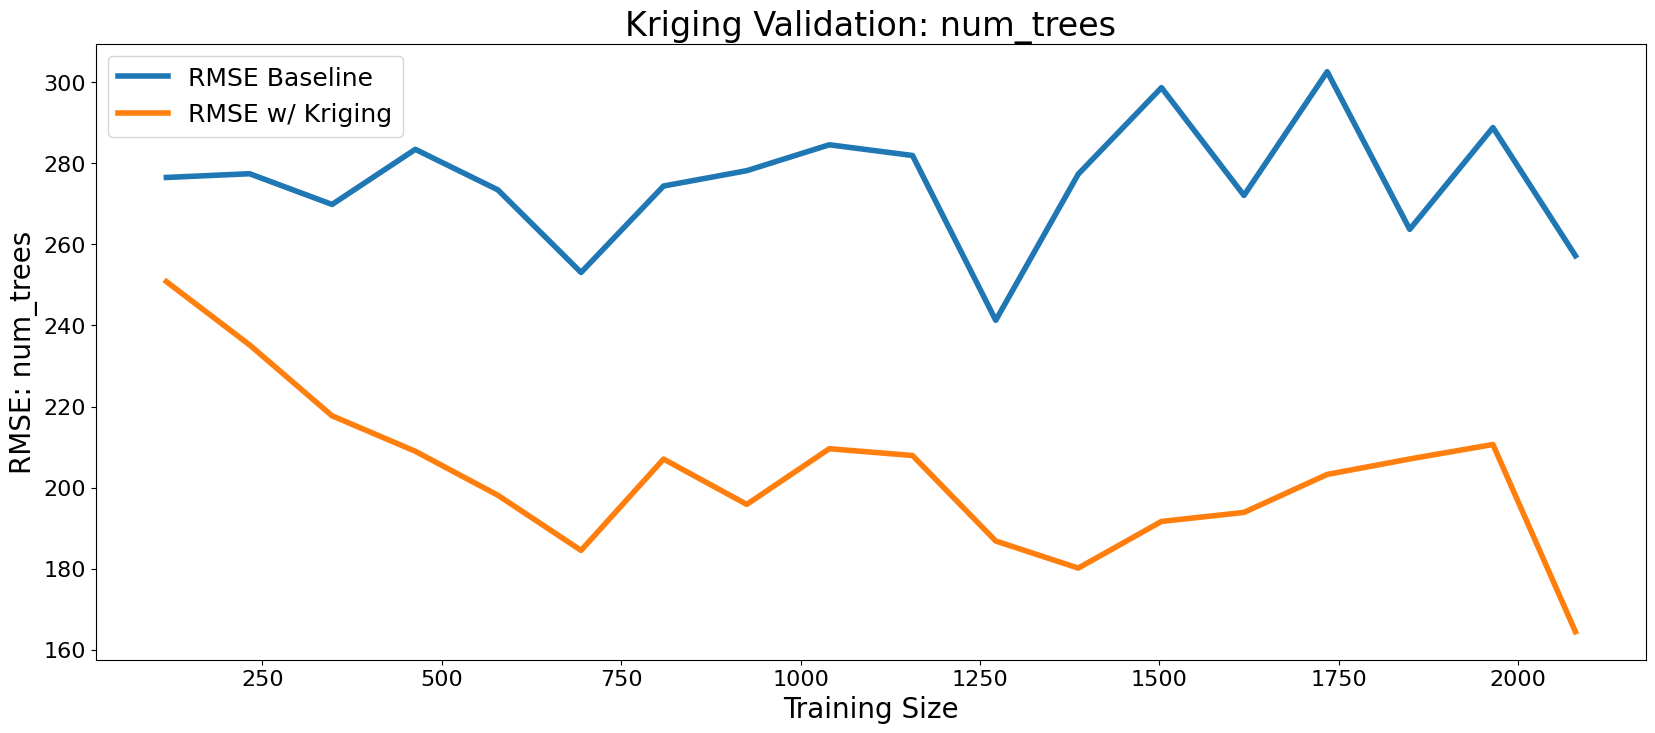

In [21]:
def lineplot(df, features, title=None):
    ''' Parameters
        ----------
        df : Pandas dataframe
        features: list
            one or more features to be plotted
        title: str, optional
            title for chart
        
        Yields
        -------
        matplotlib object
            One or more overlayed lineplots'''
    
    
    plt.figure(figsize=(20, 8));
    for feat in features:
        x = df['Training Size']
        y = df[feat]
        ax= sns.lineplot(x=x, y= y, label=feat, linewidth = 4)
    ax.set_title(title, fontsize=24);
    ax.set_ylabel('RMSE: num_trees', fontsize=20);
    ax.set_xlabel('Training Size', fontsize=20);
    ax.legend(prop=dict(size=18));
    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);


lineplot(df_krig, ['RMSE Baseline','RMSE w/ Kriging'], title='Kriging Validation: num_trees')

### Apply Kriging to our unknown data

In [53]:
# loop through each column and year, separate the data into known observations and unknown

cols_to_interpolate = df.columns.drop(['NAME','full_tract', 'GEOID','year',"random_lat", "random_lon"])
timeframe = df.year.unique()
all_estimates = {}

for yr in timeframe:
    df_yr = df[df.year==yr]
    all_estimates[yr] = {}
    print(yr)
    
    for col in cols_to_interpolate:  # loop through each column

        if col in ['num_citibike_rides'] and yr in ['2010','2011','2012']:
            continue
            
        # separate the df into the rows we use to train kriging, and the rows with unknown values
        df_estimates = df_yr[df_yr[col].isnull()][['GEOID','random_lat','random_lon']]
        df_known = df_yr.drop(df_estimates.index)[['random_lat','random_lon',col]]
        
        all_estimates[yr][col] = kriging(df_known, df_estimates)
        

2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023


In [54]:
# add the estimated Kriging data back into the main dataset

all_yrs_interpolated = []

for yr in timeframe:
    df_yr = df[df.year==yr]
    
    for col in cols_to_interpolate:  # loop through each column
        if col in ['num_citibike_rides'] and yr in ['2010','2011','2012']:
            continue

        df_yr = df_yr.merge(all_estimates[yr][col].drop(['random_lat','random_lon'], axis=1), on='GEOID', how='left')
        df_yr[col] = df_yr[col].fillna(df_yr['estimated_'+col])
        df_yr.drop(['estimated_'+col], axis=1, inplace=True)
    all_yrs_interpolated.append(df_yr)
df = pd.concat(all_yrs_interpolated)


In [55]:
# change values that were made negative percentages by Kriging to Zero
to_change = ['percent_work_agriculture', 'percent_out_of_county','percent_bike_commute','percent_walk_commute','percent_black','percent_native','percent_asian','percent_pacific','percent_out_of_state','percent_hh_rented','percent_hh_solar','num_evictions_commercial','num_evictions_residential'] 
for col in to_change:
    df[col] = np.where(df[col]<0, 0, df[col])
df.describe()

,total_pop,percent_hh_income_assist,percent_hh_snap,percent_hh_english,percent_work_agriculture,percent_work_construction,percent_work_retail,percent_work_finance,percent_work_stem,percent_work_edu_health,percent_work_art,percent_out_of_county,percent_moved_within_county,percent_public_transit,percent_drive_commute,percent_bike_commute,percent_walk_commute,percent_wfh,percent_white,percent_black,percent_native,percent_asian,percent_pacific,percent_latino,percent_bachelors,percent_grad,percent_born_citizen,percent_naturalized_citizen,percent_not_citizen,percent_same_house_1yr,percent_out_of_state,med_income,med_rent_acs,med_age,percent_hh_rented,med_value,percent_hh_electric,percent_hh_solar,med_hh_age,med_hh_tenure,num_citibike_rides,num_trees,med_rent,num_affordable_hous_built,num_bikelanes,num_evictions_commercial,num_evictions_residential,park_acres,num_parks,random_lat,random_lon
count,32550.000000,32550.000000,32550.000000,32550.000000,32550.000000,32550.000000,32550.000000,32550.000000,32550.000000,32550.000000,32550.000000,32550.000000,32550.000000,32550.000000,32550.000000,32550.000000,32550.000000,32550.000000,32550.000000,32550.000000,32550.000000,32550.000000,32550.000000,32550.000000,32550.000000,32550.000000,32550.000000,32550.000000,32550.000000,32550.000000,32550.000000,32550.000000,32550.000000,32550.000000,32550.000000,3.255000e+04,32550.000000,32550.000000,32550.000000,32550.000000,3.255000e+04,32550.000000,32550.000000,32550.000000,32550.000000,32550.000000,32550.000000,32550.000000,32550.000000,32550.000000,3.255000e+04
mean,3712.631650,0.044891,0.201002,0.499560,0.001127,0.054167,0.096216,0.088727,0.123242,0.279635,0.099687,0.020535,0.057604,0.241019,0.135962,0.004899,0.042492,0.027679,0.424663,0.252507,0.004440,0.137505,0.000587,0.266501,0.147862,0.102638,0.594094,0.209620,0.160215,0.885866,0.013739,67422.640584,1466.955352,37.363926,0.404553,6.349575e+05,0.091680,0.000522,64.722067,19.919876,1.250146e+04,287.569496,2270.466080,0.247619,9.738280,0.399393,5.707244,65.030729,1.076221,200182.724377,1.007436e+06
std,1943.917196,0.042963,0.151587,0.213185,0.005038,0.043917,0.045292,0.060107,0.067170,0.097714,0.061323,0.030490,0.041249,0.093874,0.089945,0.009213,0.051972,0.034432,0.292432,0.293148,0.011634,0.162223,0.006247,0.219638,0.087770,0.093442,0.148380,0.100431,0.092349,0.073918,0.024362,33979.142031,493.958723,6.688770,0.357337,3.026051e+05,0.105224,0.003739,26.170565,4.974997,5.126979e+04,278.391033,628.249774,1.206404,18.662133,0.919462,7.778601,229.945861,1.420088,30541.157488,2.441724e+04
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2499.000000,231.000000,1.900000,0.000000,9.999000e+03,0.000000,0.000000,0.000000,3.000000,0.000000e+00,-29.253534,787.929593,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,122372.725566,9.183651e+05
25%,2398.000000,0.015060,0.086440,0.323078,0.000000,0.023306,0.066847,0.051265,0.078711,0.211575,0.059153,0.004564,0.030629,0.176592,0.064657,0.000000,0.014426,0.007717,0.149130,0.022396,0.000000,0.023016,0.000000,0.096963,0.085526,0.038271,0.490211,0.129130,0.094574,0.857989,0.000000,44064.750000,1173.706161,33.200000,0.000310,4.391000e+05,0.030818,0.000000,60.000000,16.000000,0.000000e+00,145.000000,1900.182418,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,176242.921038,9.930995e+05
50%,3518.000000,0.033333,0.164110,0.505228,0.000000,0.047211,0.092502,0.076457,0.109049,0.274709,0.088863,0.013915,0.051768,0.236145,0.113525,0.000000,0.028902,0.016387,0.399300,0.100342,0.000000,0.074292,0.000000,0.189648,0.129871,0.074361,0.594694,0.197958,0.144267,0.898910,0.005889,61786.000000,1391.000000,36.800000,0.407745,5.688000e+05,0.058036,0.000000,73.000000,20.000000,0.000000e+00,219.000000,2239.441553,0.000000,3.000000,0.000000,3.00000

In [56]:
# df.to_parquet('Data/Cleaned/after_kriging.parquet')

In [108]:
# df[df.full_tract=='047042300'] # my bushwick neighborhood
# df[df.full_tract=='047026500'] # my bedstuy neighborhood